# Travel Insurance Analytics: Insurance Claim for Coverage

## Business Problem Understanding

**Context**  
Asuransi perjalanan adalah jenis asuransi yang memberikan perlindungan selama kita bepergian baik di dalam negeri maupun ke luar negeri. Beberapa negara bahkan mewajibkan wisatawan memiliki asuransi perjalanan, misalnya, negara-negara di Eropa dan Amerika. Jumlah premi tergantung pada cakupan yang diinginkan, perjalanan, dan tujuan perjalanan. Sebuah perusahaan yang bergerak dalam asuransi perjalanan ingin mengetahui siapa saja pemegang polis asuransi yang akan diterima klaim asuransinya. Hal ini akan membantu mengurangi beban, kinerja dan waktu serta kualitas pelayanan penyedia asuransi perjalanan kepada para pelaku perjalanan.
Target :

No (0) : Pemilik Asuransi tidak melakukan klaim

Yes (1) : Pemilik Asuransi melakukan klaim

**Problem Statement :**

Strategi marketing yang ada saat ini tidak efisien karena tidak membedakan pelanggan, sehingga mengakibatkan pemborosan sumber daya dan hilangnya peluang engagement dari calon pelanggan. Perusahaan ingin secara efektif membedakan dan menargetkan calon pelanggan yang mungkin akan melakukan klaim, sehingga mengoptimalkan sumber daya dan meningkatkan kepuasan calon pelanggan.

**Goals :**

Berdasarkan permasalahan tersebut, perusahaan ingin menerapkan model prediktif untuk membedakan pelanggan berdasarkan kemungkinan klaim mereka akan diterima sehingga tidak membuang percuma waktu dan biaya marketing. 

Selain itu, perusahaan ingin mengidentifikasi faktor-faktor yang mempengaruhi persetujuan klaim untuk meningkatkan proses keputusan dan layanan pelanggan.

**Analytic Approach :**

Langkah pertama adalah menganalisis data historis untuk mengidentifikasi tren dan pola yang membedakan antara klaim yang seharusnya disetujui dan yang tidak. Selanjutnya, kita membangun model klasifikasi yang dapat membantu perusahaan untuk memprediksi klaim yang diterima dan yang ditolak.

**Metric Evaluation**

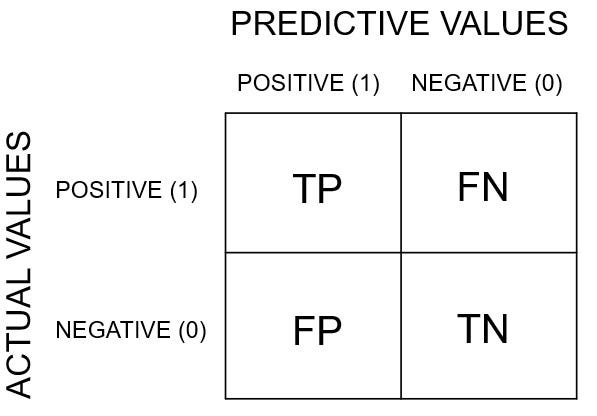

- True Positive: Calon pelaku perjalanan melakukan Claim dan diprediksi model melakukan Claim
- False Positive: Calon pelaku perjalanan tidak melakukan Claim, namun diprediksi model melakukan Claim
- False Negative: Calon pelaku perjalanan melakukan Claim, namun diprediksi model tidak melakukan Claim
- True Negative: Calon pelaku perjalanan tidak melakukan Claim dan diprediksi model tidak melakukan Claim

Error type 1 (False Positive):
Konsekuensi: Biaya pemasaran dan sumber daya perusahaan terbuang percuma.

Error type 2 (False Negative):
Konsekuensi: Kehilangan calon potensial.

Berdasarkan konsekuensi dari setiap jenis kesalahan, fokus utama dari model yang akan kita buat adalah meminimalkan Error type 2 karena konsekuensi dari False Negative lebih serius daripada False Positives (Type I error). Error tipe 2 ini jenis kesalahan ini berpotensi menurunkan pendapatan perusahaan yang diakibatkan dari kehilangan calon pelanggan potensial. Jadi nanti metric utama yang akan kita gunakan adalah recall score.


## Data Understanding

### Attribute Information

| Attribute | Data Type, Length | Description |
| --- | --- | --- |
| Agency | object | Name of agency |
| Agency Type | object | Type of travel insurance agencies |
| Distribution Channel | object | Channel of travel insurance agencies |
| Product Name | object | Name of the travel insurance products |
| Gender | object | Gender of insured |
| Duration | Int | Duration of travel |
| Destination | object | Destination of travel |
| Net Sales | Float | Amount of sales of travel insurance policies |
| Commission (in value) | Float | Commission received for travel insurance agency |
| Age | Int | Age of insured |
| Claim | Text | No – Claim status is rejected, Yes – Claim status is accepted |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno

from scipy.stats import yeojohnson, probplot

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.preprocessing import PolynomialFeatures

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data_travel_insurance.csv')
df

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No


In [3]:
# Cek info lebih detail untuk setiap fitur
listItem = []

for col in df.columns:
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col]))*100, 2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)])

pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Agency,object,0,0.00,16,"[CWT, CBH]"
1,Agency Type,object,0,0.00,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.00,2,"[Online, Offline]"
3,Product Name,object,0,0.00,26,"[Annual Travel Protect Silver, Individual Comp..."
4,Gender,object,31647,71.39,2,"[F, M]"
5,Duration,int64,0,0.00,437,"[67, 187]"
6,Destination,object,0,0.00,138,"[NORTHERN MARIANA ISLANDS, CANADA]"
7,Net Sales,float64,0,0.00,1006,"[287.4, 6.42]"
8,Commision (in value),float64,0,0.00,915,"[47.29, 2.96]"
9,Age,int64,0,0.00,89,"[23, 26]"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


Berdasarkan analisis awal fitur-fitur dalam dataset:

1. Tidak ada nilai yang hilang untuk sebagian besar fitur, kecuali kolom Gender yang memiliki sekitar 71.39% nilai yang hilang.
1. Ada beberapa fitur kategorikal seperti Agency, Agency Type, Distribution Channel, Product Name, Gender, Destination dan Claim.
1. Fitur-fitur numerik mencakup Duration, Net Sales, Commision (in value), dan Age.

In [5]:
display(df.describe(include='number'))
display(df.describe(include='object'))

,Duration,Net Sales,Commision (in value),Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600
std,109.153961,48.661970,19.625637,13.954926
min,-1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


,Agency,Agency Type,Distribution Channel,Product Name,Gender,Destination,Claim
count,44328,44328,44328,44328,12681,44328,44328
unique,16,2,2,26,2,138,2
top,EPX,Travel Agency,Online,Cancellation Plan,M,SINGAPORE,No
freq,24656,32113,43572,12979,6504,9267,43651


Berikut adalah ringkasan statistik untuk fitur numerik dan kategorikal:

1. Fitur Numerik:
    1. Duration: Waktu asuransi berlangsung. Ada durasi dengan nilai negatif yang mungkin perlu diperbaiki.
    1. Net Sales: Nilai penjualan bersih. Ada nilai negatif yang mungkin memerlukan investigasi lebih lanjut.
    1. Commision (in value): Komisi yang diterima. Sebagian besar entri memiliki komisi nol.
    1. Age: Usia klien. Ada entri dengan usia 0 dan 118 dengan median 36. usia 118 mungkin perlu diverifikasi.

1. Fitur Kategorikal:
    1. Agency: Ada 16 agency unik, dengan agen EPX sebagai agen yang paling sering muncul.
    1. Agency Type: Ada 2 tipe agency, dengan "Travel Agency" sebagai tipe yang paling dominan.
    1. Distribution Channel: Sebagian besar asuransi dijual secara online.
    1. Product Name: Ada 26 produk asuransi unik, dengan "Cancellation Plan" sebagai produk yang paling sering muncul.
    1. Gender: Hanya sekitar 28.61% entri yang memiliki informasi gender, dengan jenis kelamin M (pria) sedikit lebih dominan.
    1. Destination: Ada 138 tujuan unik, dengan Singapura sebagai tujuan yang paling sering muncul.
    1. Claim: Ada 2 unik value, dengan "No" sebagai value yang paling dominan.

### Numerik

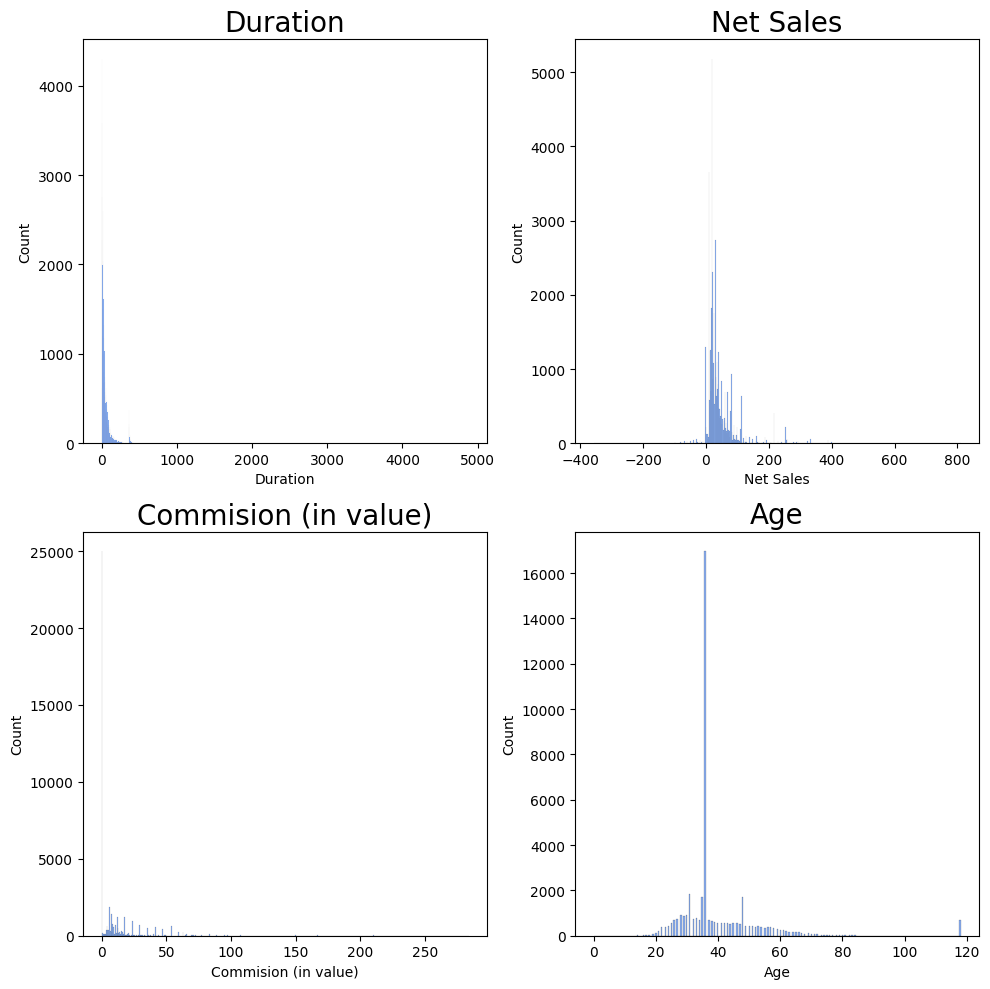

In [6]:
plt.figure(figsize=(10, 10))
plotnumber = 1
num_features = df.select_dtypes(include='number').columns

for feature in num_features:
    ax = plt.subplot(2, 2, plotnumber)
    sns.histplot(data=df,x=feature,color='cornflowerblue')
    plt.title(feature, fontsize=20)
    plotnumber += 1
    plt.tight_layout()

Visualisasi Distribusi dengan Histogram:

1. Duration: Sebagian besar data berkonsentrasi di sekitar angka rendah, tetapi ada beberapa data yang memiliki durasi yang sangat tinggi. Ini menunjukkan adanya kemungkinan outlier.
1. Net Sales: Distribusi tampaknya mendekati normal tetapi memiliki beberapa outlier di bagian kanan.
1. Commision (in value): Kebanyakan data berada di angka rendah dengan beberapa nilai yang lebih tinggi, menunjukkan kemungkinan outlier.
1. Age: Kebanyakan data berkonsentrasi di sekitar usia 30-50, tetapi ada beberapa data di atas usia 100, yang mungkin perlu diverifikasi lebih lanjut.
1. Claim: untuk claim karena hanya binary jadi distribusi data hanya di 0 dan 1.

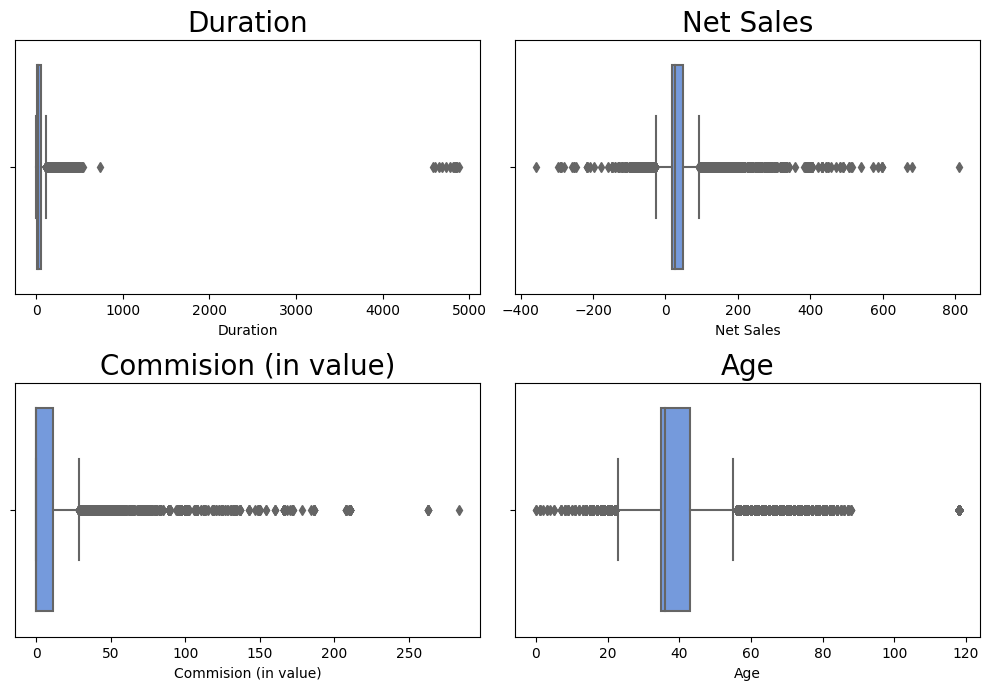

In [7]:
plt.figure(figsize=(10, 10))
plotnumber = 1
num_features = df.select_dtypes(include='number').columns

for feature in num_features:
    ax = plt.subplot(3, 2, plotnumber)
    sns.boxplot(data=df,x=feature,color='cornflowerblue')
    plt.title(feature, fontsize=20)
    plotnumber += 1
    plt.tight_layout()

Visualisasi Outliers dengan Boxplot:

1. Duration: Ada banyak outlier di atas, yang menunjukkan beberapa transaksi dengan durasi yang sangat panjang.
1. Net Sales: Ada beberapa outlier pada kolom net sales.
1. Commision (in value): Beberapa outlier di bagian atas menunjukkan komisi yang tinggi untuk beberapa transaksi.
1. Age: Seperti yang disebutkan sebelumnya, ada beberapa data untuk usia di atas 100 yang mungkin perlu diverifikasi.
1. Claim: untuk claim karena hanya binary jadi distribusi data hanya di 0 dan 1.

jelaskan outliers

In [8]:
df_numerik = df.select_dtypes(exclude='object')
df_numerik

,Duration,Net Sales,Commision (in value),Age
0,365,216.0,54.00,57
1,4,10.0,0.00,33
2,19,22.0,7.70,26
3,20,112.0,0.00,59
4,8,16.0,4.00,28
...,...,...,...,...
44323,14,30.0,0.00,36
44324,17,79.2,47.52,47
44325,64,30.0,10.50,50
44326,51,36.0,0.00,36


#### Korelasi Data

Text(0.5, 1.0, 'Correlation Matrix')

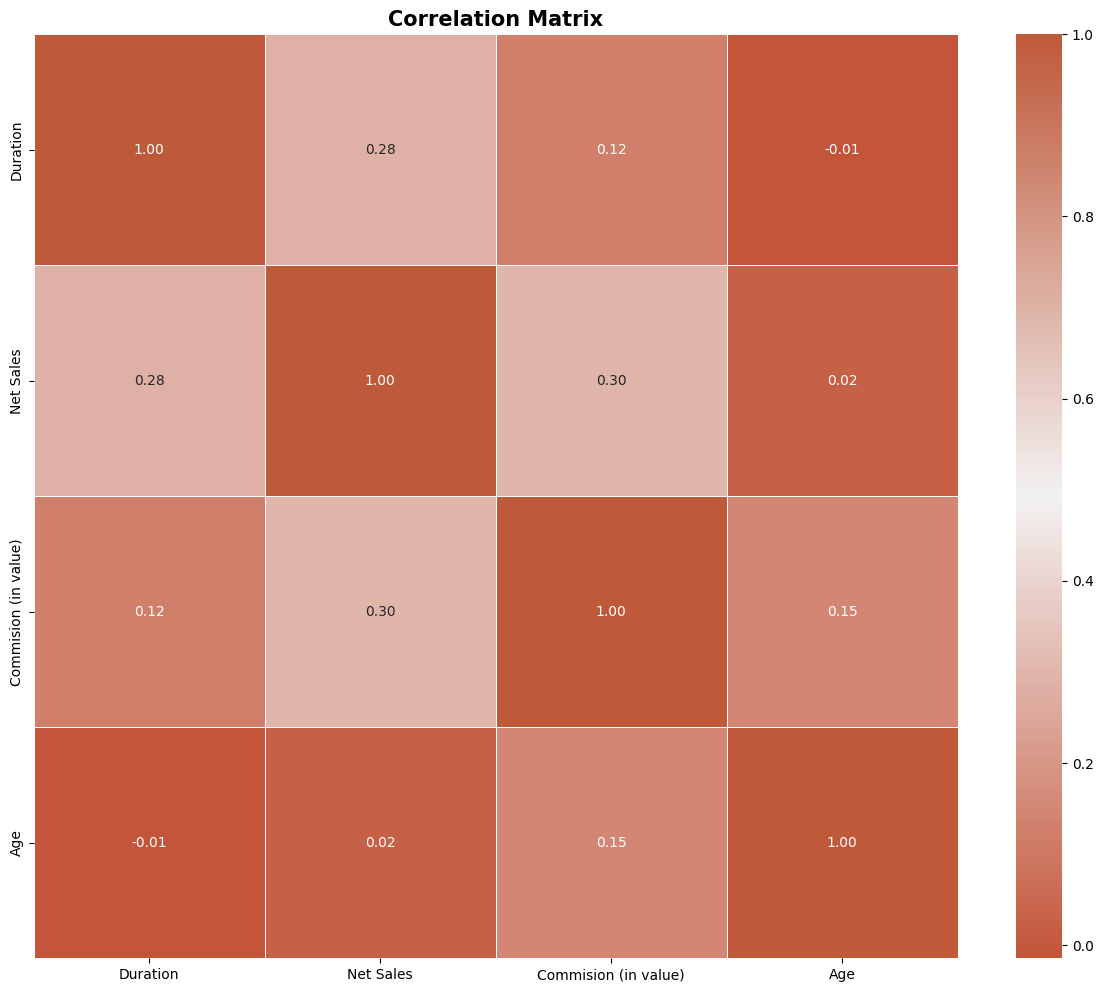

In [9]:
plt.figure(figsize = (15, 12))
palette = sns.diverging_palette(20, 22, n = 256)
corr = df_numerik.corr(method='spearman')
sns.heatmap(corr, annot = True, fmt = '.2f', cmap = palette, square = True, linewidths = .5)
plt.title('Correlation Matrix', size = 15, weight = 'bold')

Secara garis besar:  
* kolom `Net Sales` memiliki korelasi yang cukup tinggi terhadap kolom `Commision (in value)`.

#### Multicollinearity

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Extract numerical variables for VIF calculation
df_numerik

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data['Feature'] = df_numerik.columns
vif_data['VIF'] = [variance_inflation_factor(df_numerik.values, i) for i in range(len(df_numerik.columns))]

vif_data

,Feature,VIF
0,Duration,1.430126
1,Net Sales,2.965873
2,Commision (in value),2.153032
3,Age,1.619282


Berdasarkan perhitungan Variance Inflation Factor (VIF):

Duration: VIF sekitar 1.09, yang jauh di bawah ambang batas umum 5 atau 10, menunjukkan tidak ada multikolinearitas.
Net Sales: VIF sekitar 1.14, juga menunjukkan tidak ada multikolinearitas.
Commision: VIF sekitar 1.12, menunjukkan tidak ada multikolinearitas.
Age: VIF sekitar 1.05, menunjukkan tidak ada multikolinearitas.
VIF untuk semua variabel independen di bawah ambang batas umum (5 atau 10), yang menunjukkan bahwa tidak ada multikolinearitas yang serius di antara variabel ini.

### Kategorik

In [11]:
df_katogerik = df.select_dtypes(include='object')

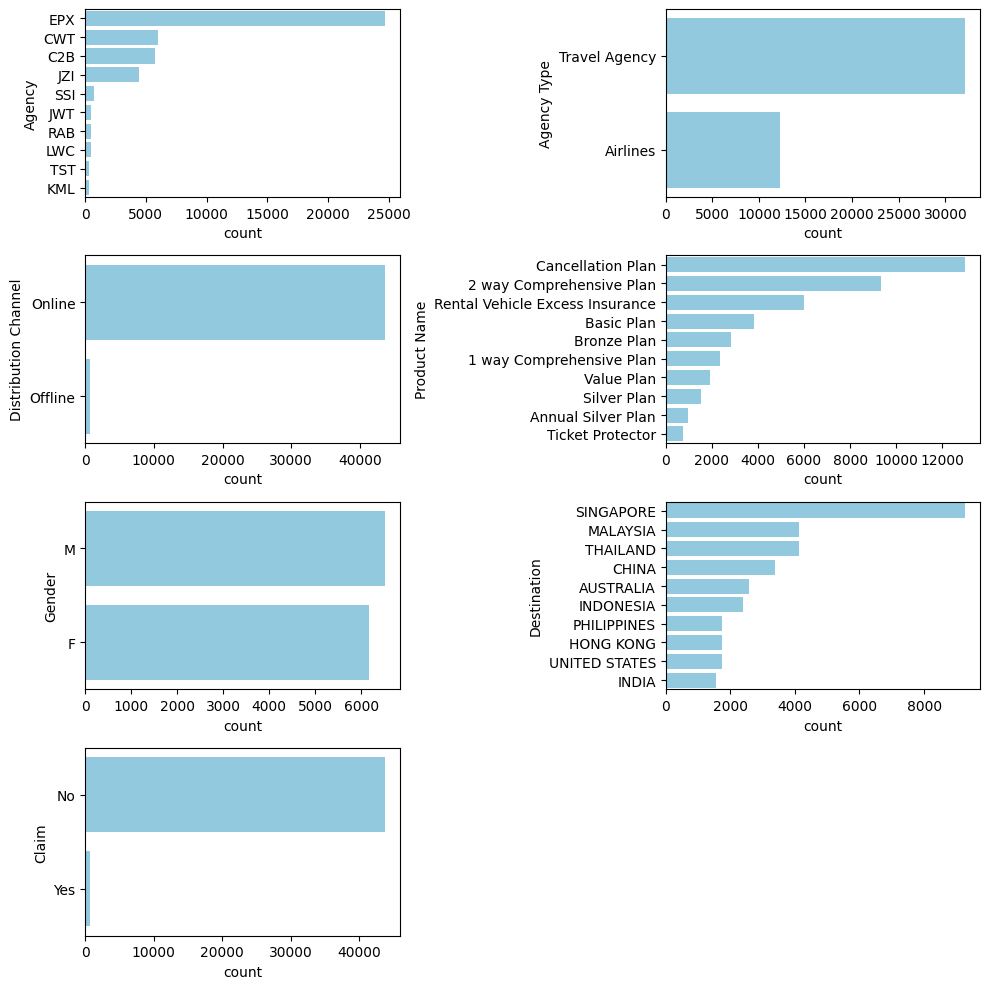

In [12]:
count = 0
fig = plt.figure(figsize=(10,10))
for kolom in df_katogerik.columns:
    count += 1
    plt.subplot(4,2,count)
    sns.countplot(y = kolom, data = df_katogerik, order = df_katogerik[kolom].value_counts().sort_values(ascending = False).head(10).index, color= 'skyblue')
    fig.tight_layout()
plt.show()

1. Agency: EPX adalah agen dengan jumlah transaksi terbanyak, diikuti oleh C2B.
1. Agency Type: Kebanyakan transaksi adalah dari tipe Travel Agency.
1. Distribution Channel: Hampir semua transaksi dilakukan melalui saluran online.
1. Product Name: Produk dengan nama "Cancellation Plan" dan "2-way Comprehensive Plan" adalah produk yang paling banyak dijual.
1. Destination: Kebanyakan pelanggan memilih destinasi di Asia, khususnya ke Singapura.

## Data Cleaning

In [13]:
df_copy = df

Selanjutnya kita merubah kolom 'Claim' yang merupakan kolom target menjadi nilai 0 untuk tidak Claim dan 1 untuk yang Claim

In [14]:
df_copy['Claim']= np.where(df_copy['Claim']=='Yes', 1, 0)

Selanjutnya kita merubah nama kolom `Commision (in value)` menjadi `Commision` untuk memudahkan penulisan

In [15]:
df_copy = df_copy.rename(columns = {'Commision (in value)':'Commision'})
df_copy

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision,Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,0
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,0
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,0
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,0
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,1
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,0
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,0
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,0


In [16]:
df_copy.isna().sum()

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Gender                  31647
Duration                    0
Destination                 0
Net Sales                   0
Commision                   0
Age                         0
Claim                       0
dtype: int64

In [17]:
df_copy.isna().sum()/len(df_copy)*100

Agency                   0.000000
Agency Type              0.000000
Distribution Channel     0.000000
Product Name             0.000000
Gender                  71.392799
Duration                 0.000000
Destination              0.000000
Net Sales                0.000000
Commision                0.000000
Age                      0.000000
Claim                    0.000000
dtype: float64

### Missing Value

Selanjutnya, kita akan memvisualisasikan missing values/data yang hilang pada dataframe kita dengan menggunakan library missingno


In [18]:
df_copy.isna().sum()

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Gender                  31647
Duration                    0
Destination                 0
Net Sales                   0
Commision                   0
Age                         0
Claim                       0
dtype: int64

In [19]:
df_copy.isna().sum()/len(df_copy)*100

Agency                   0.000000
Agency Type              0.000000
Distribution Channel     0.000000
Product Name             0.000000
Gender                  71.392799
Duration                 0.000000
Destination              0.000000
Net Sales                0.000000
Commision                0.000000
Age                      0.000000
Claim                    0.000000
dtype: float64

<Axes: >

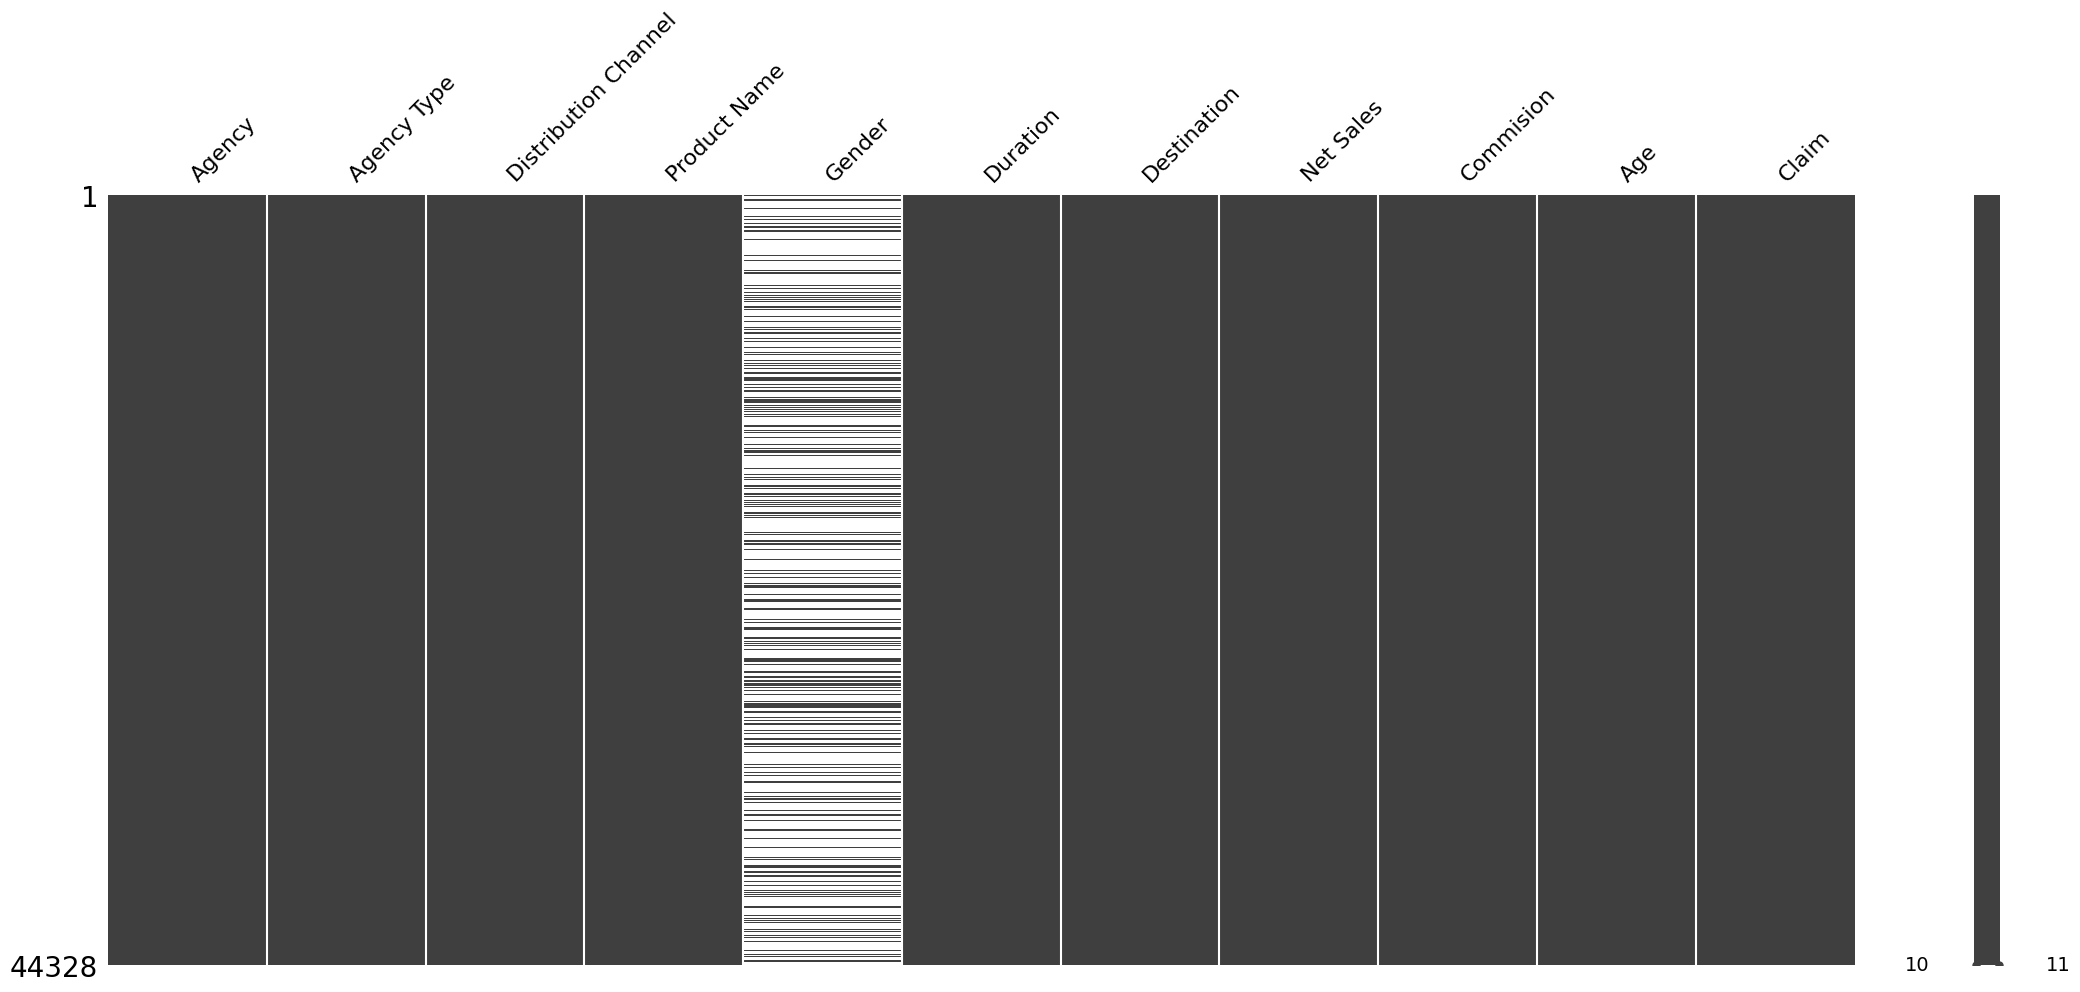

In [20]:
missingno.matrix(df_copy)

Terlihat bahwa missing value/data yang hilang pada kolom `Gender` memiliki pola yang cukup acak yang mungkin karena kesalahan penulisan atau pemegang polis tidak ingin menulis gendernya. Kolom `Gender` memiliki sekitar 71,39% nilai yang hilang. Mengingat persentase yang tinggi dari nilai yang hilang, untuk menjaga kesederhanaan dan mempertahankan sebanyak mungkin informasi, saya akan mengisi nilai-nilai yang hilang dengan placeholder seperti `Not Specific`.

In [21]:
df_copy['Gender'].fillna('Not Specific', inplace=True)

In [22]:
df_copy.isna().sum()/len(df_copy)*100

Agency                  0.0
Agency Type             0.0
Distribution Channel    0.0
Product Name            0.0
Gender                  0.0
Duration                0.0
Destination             0.0
Net Sales               0.0
Commision               0.0
Age                     0.0
Claim                   0.0
dtype: float64

### Claim (Variable Target)

In [23]:
df_copy['Claim'].value_counts()/len(df_copy)*100

Claim
0    98.472749
1     1.527251
Name: count, dtype: float64

berdasarkan dari data diatas, variable target `Claim` memiliki value data yang imbalance

In [24]:
df_copy[df_copy['Claim'] == 1]

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision,Age,Claim
13,C2B,Airlines,Online,Annual Silver Plan,F,376,SINGAPORE,252.85,63.21,43,1
21,JZI,Airlines,Online,Basic Plan,M,12,VIET NAM,30.00,10.50,35,1
28,C2B,Airlines,Online,Bronze Plan,F,30,SINGAPORE,16.00,4.00,58,1
50,LWC,Travel Agency,Online,Annual Travel Protect Gold,M,370,CHINA,204.60,132.99,39,1
102,EPX,Travel Agency,Online,2 way Comprehensive Plan,Not Specific,156,JAPAN,26.00,0.00,36,1
...,...,...,...,...,...,...,...,...,...,...,...
43963,EPX,Travel Agency,Online,2 way Comprehensive Plan,Not Specific,16,"KOREA, REPUBLIC OF",42.00,0.00,36,1
44048,C2B,Airlines,Online,Silver Plan,F,29,SINGAPORE,27.00,6.75,33,1
44182,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,Not Specific,32,AUSTRALIA,178.20,106.92,36,1
44224,C2B,Airlines,Online,Annual Silver Plan,F,390,SINGAPORE,301.00,75.25,48,1


### Kolom Durasi

In [25]:
df_copy['Duration'].describe()

count    44328.000000
mean        49.424292
std        109.153961
min         -1.000000
25%          9.000000
50%         22.000000
75%         53.000000
max       4881.000000
Name: Duration, dtype: float64

Di kolom `Duration` ini, kita memiliki nilai-nilai negatif, tetapi secara logika durasi tidak bisa negatif, selanjutnya saya akan mengubah data yang negatif menjadi data yang median

In [26]:
df10=df_copy['Duration']<0
df10.sum()

2

jadi, ada 2 nilai negatif dalam kolom `Duration`. Saya akan menggantinya dengan nilai median karena distribusi data tidak mengikuti pola normal.

In [27]:
median_duration = df_copy['Duration'].median()
df_copy['Duration'] = np.where(df_copy['Duration'] < 0, median_duration, df_copy['Duration'])


In [28]:
df_copy['Duration'].describe()

count    44328.000000
mean        49.425329
std        109.153591
min          0.000000
25%          9.000000
50%         22.000000
75%         53.000000
max       4881.000000
Name: Duration, dtype: float64

### Data Duplikat

In [29]:
df_copy[df_copy.duplicated(keep='first')].shape

(4667, 11)

ada 4.667 baris duplikat dalam dataset ini. Untuk menjaga integritas data, kita sebaiknya menghapus duplikat-duplikat ini untuk menurunkan kemungkinan model terjadi overfitting.

In [30]:
df_copy[df_copy.duplicated(keep='first')].sort_values(['Product Name','Duration', 'Age']).head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision,Age,Claim
39757,EPX,Travel Agency,Online,1 way Comprehensive Plan,Not Specific,1.0,THAILAND,20.0,0.0,28,0
2066,EPX,Travel Agency,Online,1 way Comprehensive Plan,Not Specific,1.0,SINGAPORE,20.0,0.0,36,0
2908,EPX,Travel Agency,Online,1 way Comprehensive Plan,Not Specific,1.0,SINGAPORE,20.0,0.0,36,0
3698,EPX,Travel Agency,Online,1 way Comprehensive Plan,Not Specific,1.0,VIET NAM,20.0,0.0,36,0
5820,EPX,Travel Agency,Online,1 way Comprehensive Plan,Not Specific,1.0,VIET NAM,20.0,0.0,36,0


In [31]:
df_copy = df_copy.drop_duplicates(keep='first').reset_index(drop=True)
df_copy.shape 

(39661, 11)

### Kolom Age

Untuk kolom `Age`, kita perlu melakukan investigasi lebih lanjut untuk menentukan tindakan yang sesuai terhadap outliers yang diidentifikasi sebelumnya.

In [32]:
df_copy['Age'].describe()

count    39661.000000
mean        39.930284
std         13.526346
min          0.000000
25%         34.000000
50%         36.000000
75%         45.000000
max        118.000000
Name: Age, dtype: float64

Untuk kolom Usia:

Usia maksimum adalah 118, yang juga patut dicurigai karena sangat jarang bagi individu berusia sejauh ini untuk melakukan perjalanan atau membeli asuransi perjalanan.

Untuk mengatasi nilai-nilai ekstrem dalam kolom Usia, kami akan membatasi usia minimum menjadi 0 dan usia maksimum menjadi 100. Nilai-nilai di luar rentang ini akan diatur ulang ke ambang batas ini.

In [33]:
# Capping the age values
df_copy['Age'] = np.where(df_copy['Age'] > 100, 100, df_copy['Age'])

# Display the updated statistics for the 'Age' column
df_copy['Age'].describe()


count    39661.000000
mean        39.712892
std         12.364609
min          0.000000
25%         34.000000
50%         36.000000
75%         45.000000
max        100.000000
Name: Age, dtype: float64

Skewness of Duration: 24.338167400763847
Kurtosis of Duration: 975.1490844825742


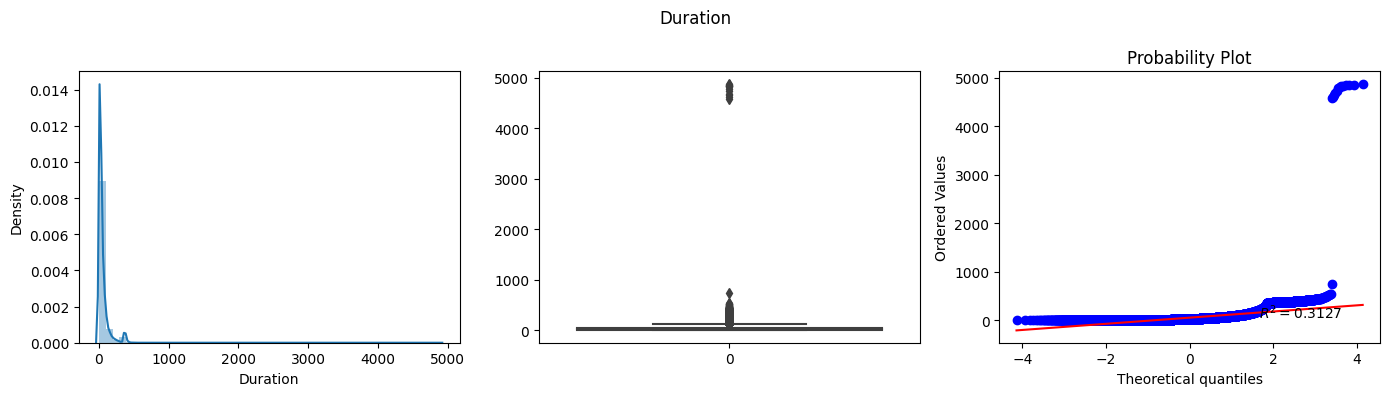

Skewness of Net Sales: 3.2093319434807923
Kurtosis of Net Sales: 18.778520162857312


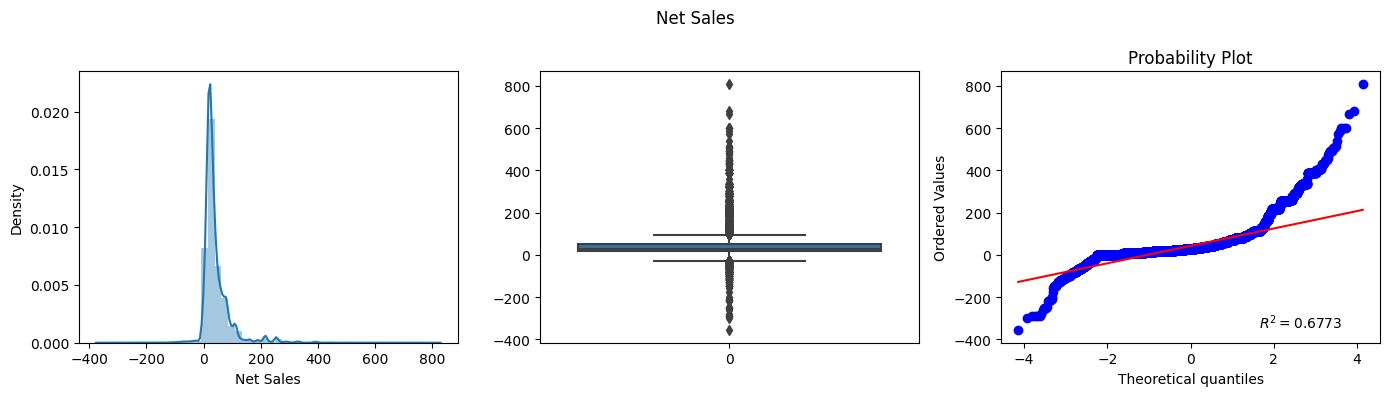

Skewness of Commision: 3.9160831256182216
Kurtosis of Commision: 23.703904257834065


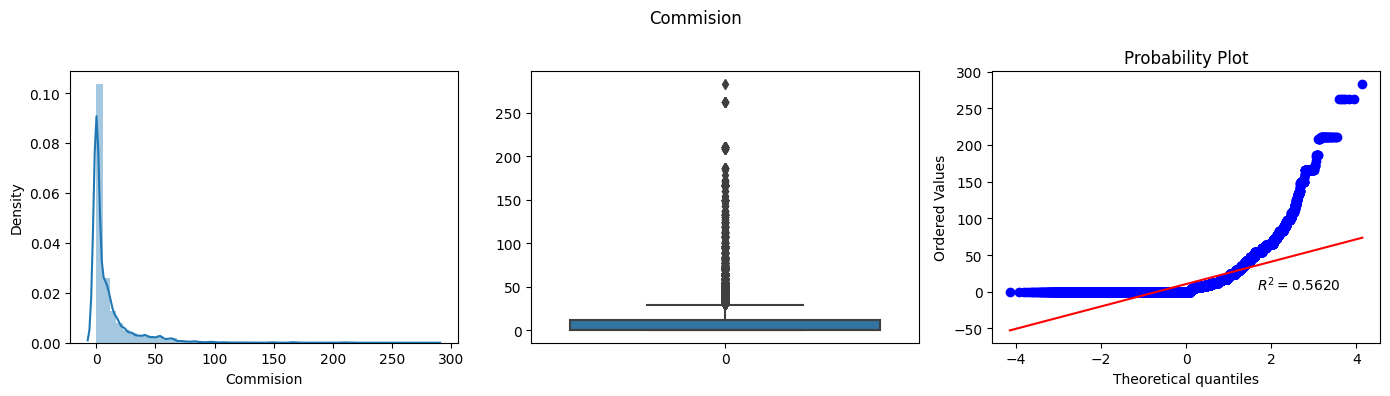

Skewness of Age: 1.9398142571851034
Kurtosis of Age: 6.0110310339509185


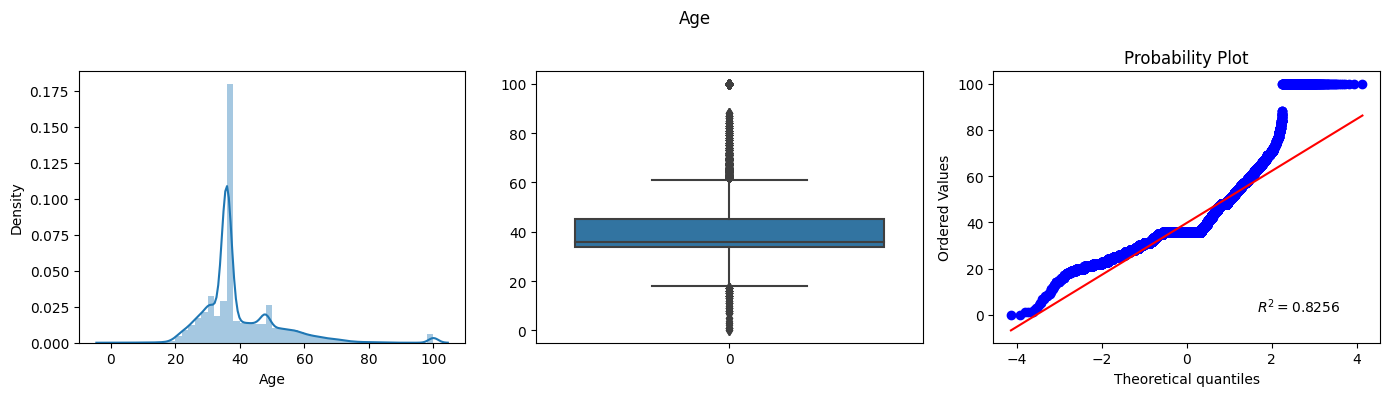

Skewness of Claim: 7.468505209155555
Kurtosis of Claim: 53.78128210536232


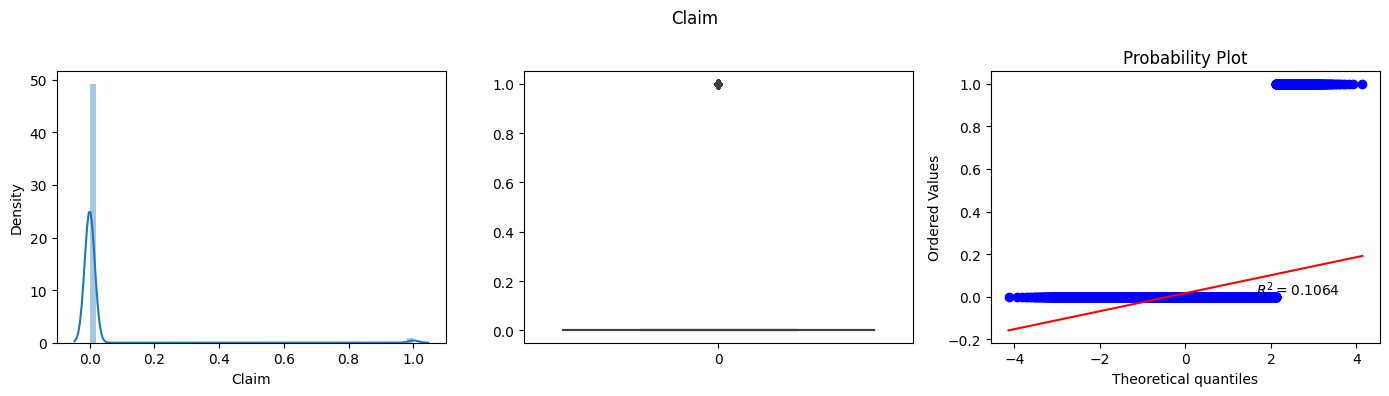

In [34]:
for col in df_copy.select_dtypes(np.number).columns:
    print(f"Skewness of {col}:",df_copy[col].skew())
    print(f"Kurtosis of {col}:",df_copy[col].kurtosis())
    plt.figure(figsize=(14,4))
    plt.subplot(131)
    sns.distplot(df_copy[col])
    plt.subplot(132)
    sns.boxplot(df_copy[col])
    plt.subplot(133)
    probplot(df_copy[col],plot=plt,rvalue=True,dist='norm')
    plt.suptitle(col)
    plt.tight_layout()
    plt.show()

## EDA

In [35]:
# Cek info lebih detail untuk setiap fitur
listItem = []

for col in df_copy.columns:
    listItem.append([col, df_copy[col].dtype, df_copy[col].isna().sum(), round((df_copy[col].isna().sum()/len(df_copy[col]))*100, 2),
                    df_copy[col].nunique(), list(df_copy[col].drop_duplicates().sample(2).values)])

pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Agency,object,0,0.0,16,"[C2B, KML]"
1,Agency Type,object,0,0.0,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.0,2,"[Offline, Online]"
3,Product Name,object,0,0.0,26,"[Basic Plan, Spouse or Parents Comprehensive P..."
4,Gender,object,0,0.0,3,"[M, F]"
5,Duration,float64,0,0.0,436,"[9.0, 474.0]"
6,Destination,object,0,0.0,138,"[RUSSIAN FEDERATION, SWITZERLAND]"
7,Net Sales,float64,0,0.0,1006,"[127.5, 323.0]"
8,Commision,float64,0,0.0,915,"[108.22, 25.55]"
9,Age,int64,0,0.0,89,"[33, 57]"


### Berdasarkan umur

In [36]:
bins = list(range(0,100,5))
bins
labels = []
for i in range(len(bins)-1):
    label = '{} - {}'.format(bins[i],bins[i+1])
    labels.append(label)
df_copy['age_group'] = pd.cut(df_copy['Age'], bins=bins, labels=labels, right=False)
df_copy

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision,Age,Claim,age_group
0,C2B,Airlines,Online,Annual Silver Plan,F,365.0,SINGAPORE,216.0,54.00,57,0,55 - 60
1,EPX,Travel Agency,Online,Cancellation Plan,Not Specific,4.0,MALAYSIA,10.0,0.00,33,0,30 - 35
2,JZI,Airlines,Online,Basic Plan,M,19.0,INDIA,22.0,7.70,26,0,25 - 30
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,Not Specific,20.0,UNITED STATES,112.0,0.00,59,0,55 - 60
4,C2B,Airlines,Online,Bronze Plan,M,8.0,SINGAPORE,16.0,4.00,28,0,25 - 30
...,...,...,...,...,...,...,...,...,...,...,...,...
39656,EPX,Travel Agency,Online,2 way Comprehensive Plan,Not Specific,14.0,CHINA,30.0,0.00,36,1,35 - 40
39657,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,Not Specific,17.0,AUSTRALIA,79.2,47.52,47,0,45 - 50
39658,TST,Travel Agency,Offline,Travel Cruise Protect,M,64.0,THAILAND,30.0,10.50,50,0,50 - 55
39659,EPX,Travel Agency,Online,2 way Comprehensive Plan,Not Specific,51.0,CHINA,36.0,0.00,36,0,35 - 40


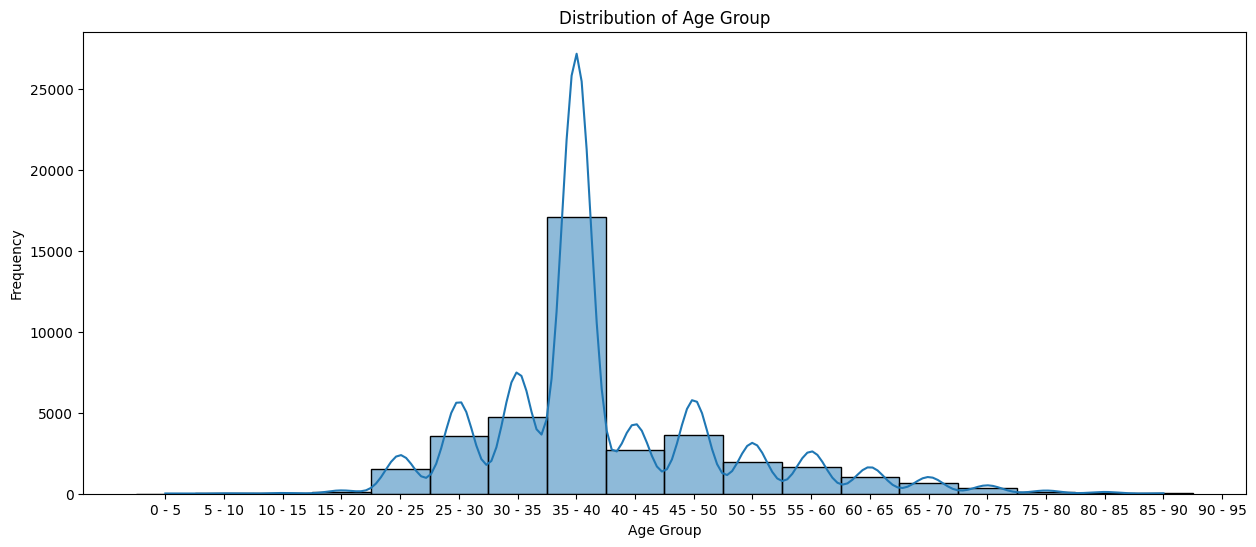

In [37]:
# Plot distribution of Age
plt.figure(figsize=(15, 6))
sns.histplot(df_copy['age_group'], kde=True, bins=30)
plt.title('Distribution of Age Group')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.show()

Distribusi kelompok umur dari pemilik asuransi perjalanan cenderung di tengah, dengan sebagian besar Distribusi umur pelanggan cenderung menceng ke kanan, dengan sebagian besar pelanggan berusia di bawah 60 tahun. berusia di antara 35 - 40 tahun.

### Berdasarkan destinasi

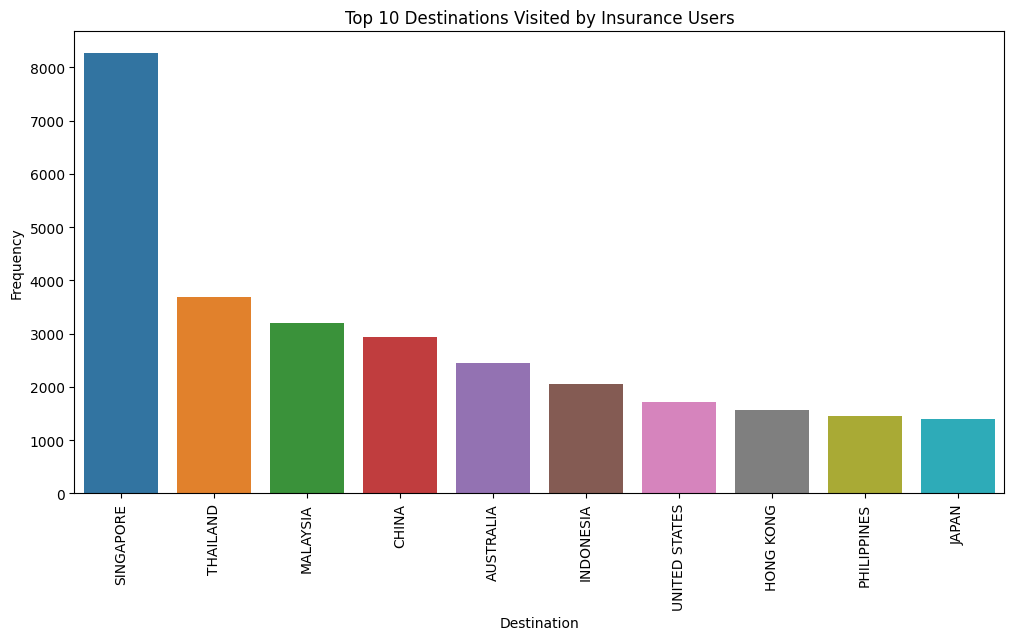

In [38]:
# Plot destination sales
plt.figure(figsize=(12, 6))
destination_count = df_copy['Destination'].value_counts().head(10)
sns.barplot(x=destination_count.index, y=destination_count.values)
plt.title('Top 10 Destinations Visited by Insurance Users')
plt.xlabel('Destination')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

Dari visualisasi di atas, kita dapat melihat bahwa "Singapore" adalah destinasi yang paling banyak dikunjungi oleh pengguna asuransi, diikuti oleh "Thailand" dan "Malaysia". Ini mungkin menunjukkan bahwa destinasi tersebut populer di kalangan wisatawan dan memiliki risiko yang lebih tinggi yang memotivasi pengguna untuk membeli asuransi perjalanan.

### Berdasarkan produk

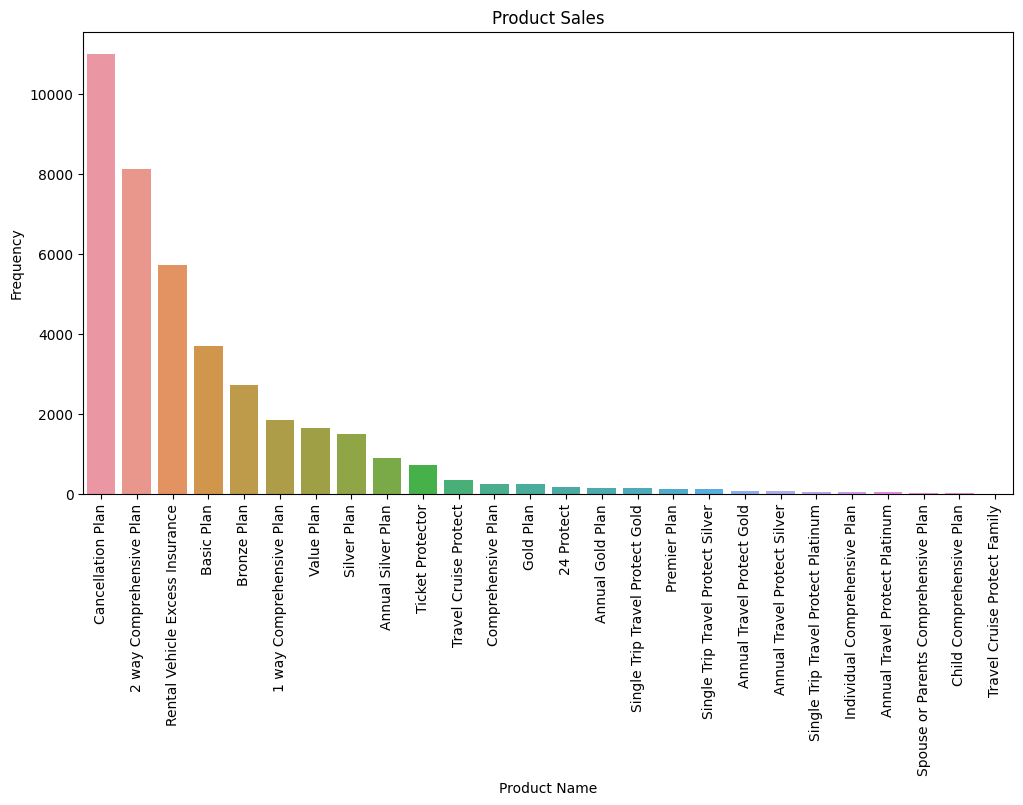

In [39]:
plt.figure(figsize=(12, 6))
product_count = df_copy['Product Name'].value_counts()
sns.barplot(x=product_count.index, y=product_count.values)
plt.title('Product Sales')
plt.xlabel('Product Name')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

Dari visualisasi di atas, kita dapat melihat bahwa "Cancellation Plan" adalah produk asuransi yang paling laris, diikuti oleh "2 way Comprehensive Plan" dan "Rental Vehicle Excess Insurance". Produk "Cancellation Plan" mungkin memiliki fitur atau harga yang menarik bagi pelanggan, sehingga menjadi pilihan yang populer.

In [40]:
# Group data by product name and calculate total net sales and total commission
product_profit = df_copy.groupby('Product Name').agg({'Net Sales': 'sum', 'Commision': 'sum'}).sort_values(by='Net Sales', ascending=False).reset_index()
product_profit.head()

,Product Name,Net Sales,Commision
0,2 way Comprehensive Plan,362932.00,0.00
1,Cancellation Plan,312061.00,0.00
2,Rental Vehicle Excess Insurance,246153.60,187371.36
3,Annual Silver Plan,196670.01,51220.41
4,Basic Plan,98665.00,35483.70


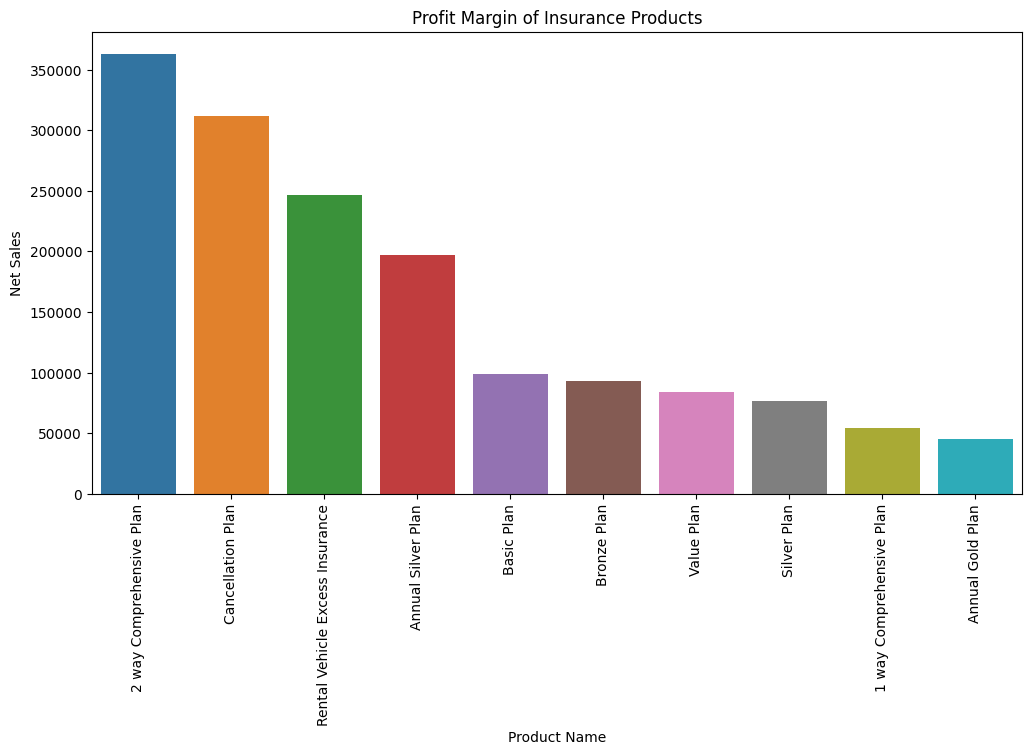

In [41]:
# Plot profit margin of products
plt.figure(figsize=(12, 6))
sns.barplot(x='Product Name', y='Net Sales', data=product_profit.head(10))
plt.title('Profit Margin of Insurance Products')
plt.xlabel('Product Name')
plt.ylabel('Net Sales')
plt.xticks(rotation=90)
plt.show()

Namun, berdasarkan dari visualisasi di atas, kita dapat melihat bahwa produk "2 way Comprehensive Plan" memiliki net sales yang paling tinggi daripada "Cancellation Plan", sehingga "2 way Comprehensive Plan" merupakan produk asuransi yang paling menguntungkan. Produk "Rental Vehicle Excess Insurance", "Annual Silver Plan", dan "Basic Plan" juga menguntungkan, namun net salesnya lebih rendah dibandingkan dua produk pertama.

### Berdasarkan Agency

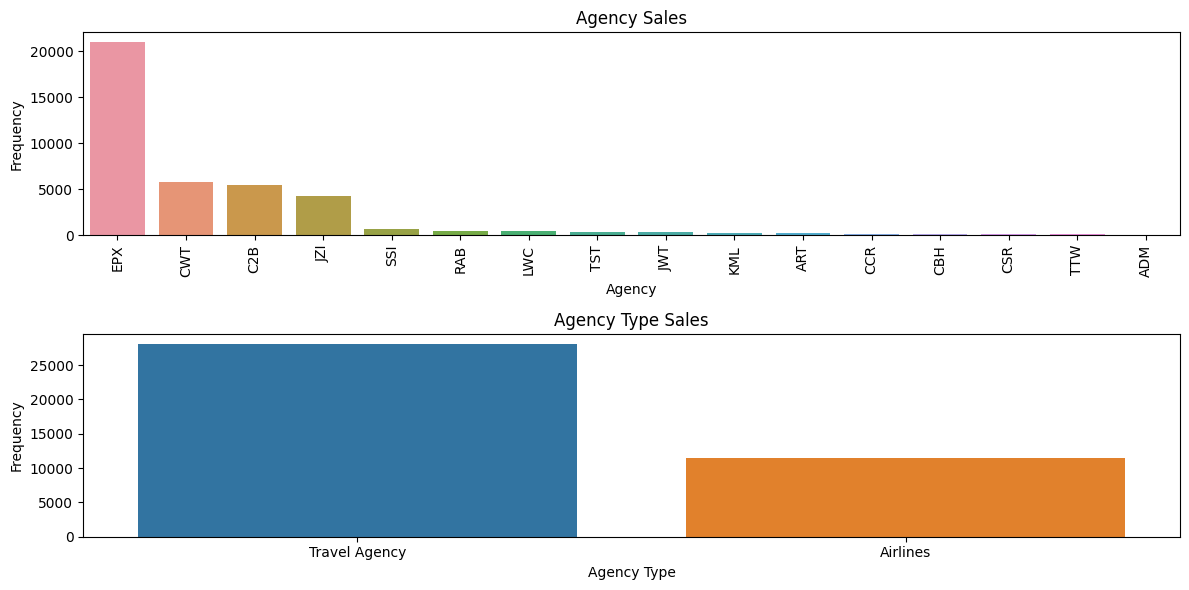

In [42]:
# Plot agency sales
plt.figure(figsize=(12, 6))

# Agency sales
plt.subplot(2, 1, 1)
agency_count = df_copy['Agency'].value_counts()
sns.barplot(x=agency_count.index, y=agency_count.values)
plt.title('Agency Sales')
plt.xlabel('Agency')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

# Agency Type sales
plt.subplot(2, 1, 2)
agency_type_count = df_copy['Agency Type'].value_counts()
sns.barplot(x=agency_type_count.index, y=agency_type_count.values)
plt.title('Agency Type Sales')
plt.xlabel('Agency Type')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Dari visualisasi di atas, kita dapat melihat bahwa:
1. "EPX" adalah agensi dengan frekuensi yang paling banyak menjual asuransi, diikuti oleh "C2B" dan "JZI".
1. "Travel Agency" adalah tipe agensi dengan frekuensi yang paling banyak menjual asuransi, dibandingkan dengan "Airlines".

Ini menunjukkan bahwa agensi perjalanan memiliki peran penting dalam penjualan asuransi perjalanan.

In [43]:
# Group data by agency name and calculate total net sales and total commission
agency_profit = df_copy.groupby(['Agency']).agg({'Net Sales': 'sum', 'Commision': 'sum'}).sort_values(by='Net Sales', ascending=False).reset_index()
agency_profit.head()

,Agency,Net Sales,Commision
0,EPX,729660.00,0.00
1,C2B,431089.71,112548.52
2,CWT,246153.60,187371.36
3,JZI,140572.00,50975.75
4,LWC,50326.20,33435.55


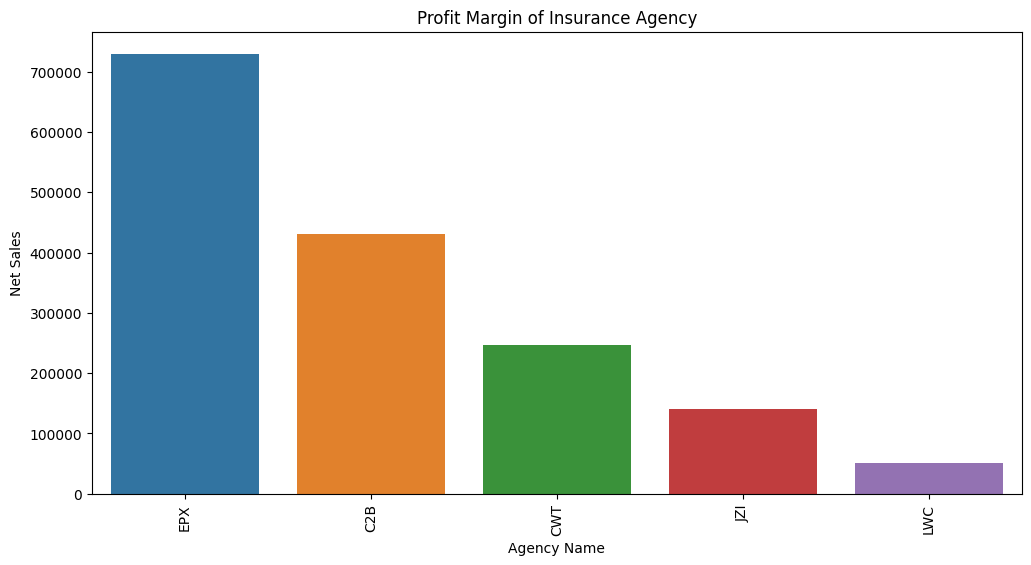

In [44]:
# Plot profit margin of products
plt.figure(figsize=(12, 6))
sns.barplot(x='Agency', y='Net Sales', data=agency_profit.head())
plt.title('Profit Margin of Insurance Agency')
plt.xlabel('Agency Name')
plt.ylabel('Net Sales')
plt.xticks(rotation=90)
plt.show()

Namun, berdasarkan dari visualisasi di atas, kita dapat melihat bahwa "EPX" adalah agensi yang paling banyak mendapatkan keuntungan dalam menjual asuransi perjalanan dengan nilai 729.660, diikuti oleh "C2B" dan "JZI".

In [45]:
# Group data by agency type and calculate total net sales and total commission
agencytype_profit = df_copy.groupby(['Agency Type']).agg({'Net Sales': 'sum', 'Commision': 'sum'}).sort_values(by='Net Sales', ascending=False).reset_index()
agencytype_profit.head()

,Agency Type,Net Sales,Commision
0,Travel Agency,1067559.80,235026.24
1,Airlines,611797.74,179138.61


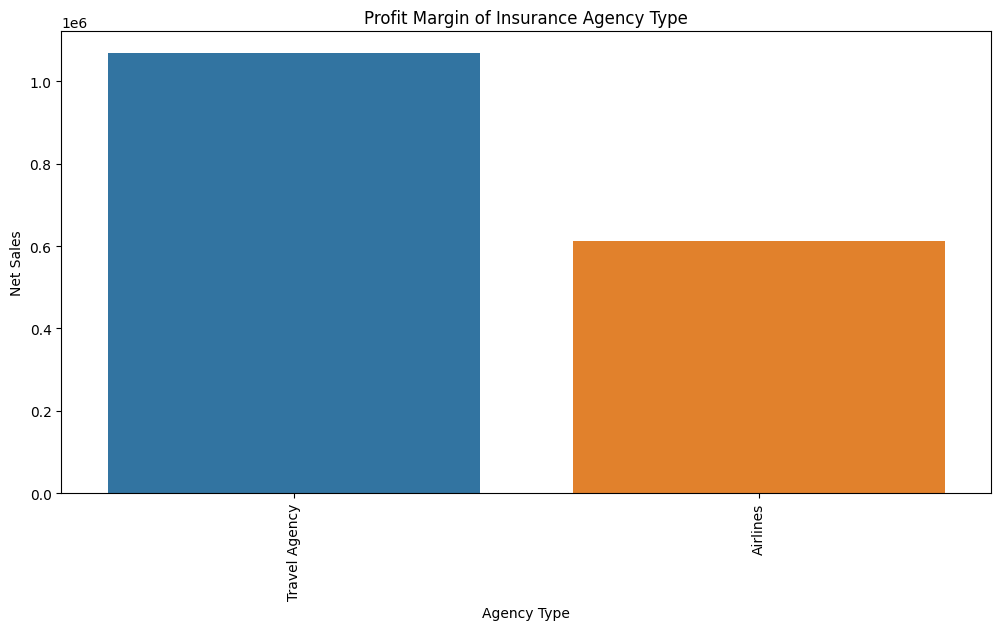

In [46]:
# Plot profit margin of products
plt.figure(figsize=(12, 6))
sns.barplot(x='Agency Type', y='Net Sales', data=agencytype_profit)
plt.title('Profit Margin of Insurance Agency Type')
plt.xlabel('Agency Type')
plt.ylabel('Net Sales')
plt.xticks(rotation=90)
plt.show()

Berdasarkan visualisasi diatas, tipe "Travel Agency" memiliki proporsi keuntungan yang hampir 2 kali lipat dibandingkan dengan tipe "Airlines".

## Feature Engineering / Data Preparation

### Data Splitting

In [47]:
X = df_copy.drop(columns = ['Claim', 'age_group'])
y = df_copy['Claim']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    stratify = y, 
    random_state = 2020)

In [48]:
y.value_counts()*100 / len(y)

Claim
0    98.298076
1     1.701924
Name: count, dtype: float64

In [49]:
df_copy.select_dtypes(include='object').nunique()

Agency                   16
Agency Type               2
Distribution Channel      2
Product Name             26
Gender                    3
Destination             138
dtype: int64

In [90]:
transformer = ColumnTransformer([
                    ('one hot encoder',OneHotEncoder(drop = 'first'),['Agency Type','Distribution Channel', 'Gender']),
                    ('binary encoder',ce.BinaryEncoder(),['Agency', 'Product Name','Destination']),
], remainder = 'passthrough')

In [91]:
testing = pd.DataFrame(transformer.fit_transform(X_train_val),columns=transformer.get_feature_names_out())
testing.head()

,one hot encoder__Agency Type_Travel Agency,one hot encoder__Distribution Channel_Online,one hot encoder__Gender_M,one hot encoder__Gender_Not Specific,binary encoder__Agency_0,binary encoder__Agency_1,binary encoder__Agency_2,binary encoder__Agency_3,binary encoder__Agency_4,binary encoder__Product Name_0,...,binary encoder__Destination_2,binary encoder__Destination_3,binary encoder__Destination_4,binary encoder__Destination_5,binary encoder__Destination_6,binary encoder__Destination_7,remainder__Duration,remainder__Net Sales,remainder__Commision,remainder__Age
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,18.0,53.5,13.38,53.0
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,19.0,80.0,0.00,36.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,7.0,13.5,3.38,56.0
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,36.0,80.0,0.00,36.0
4,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,111.0,49.0,0.00,36.0


## Modelling & Evaluation

In [52]:
logreg = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=2023)
rf = RandomForestClassifier(random_state=2023)
abc = AdaBoostClassifier(random_state=2023)
xgb = XGBClassifier(random_state=2023)
lgbm = lgb.LGBMClassifier(random_state=2023)
gbc = GradientBoostingClassifier(random_state=2023)

scaler = RobustScaler()

skfold = StratifiedKFold(n_splits=5)

In [53]:
models = [logreg,knn,dt,rf,abc,xgb,lgbm,gbc]
list_model = []
score = []
std = []

for i in models:
    estimator=Pipeline([
        ('preprocess',transformer),
        ('scaler',scaler),
        ('model',i)])
    model_cv=cross_val_score(estimator,X_train_val,y_train_val,cv=skfold,scoring = 'recall')

    list_model.append(i)
    score.append(model_cv.mean())
    std.append(model_cv.std())

pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest','AdaBoost', 'XGBoost', 'LightGBM', 'Gradient Boosting'],'recall_score':score,'sdev':std}).set_index('model').sort_values(by='recall_score',ascending=False)

[LightGBM] [Info] Number of positive: 432, number of negative: 24950
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 25382, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017020 -> initscore=-4.056204
[LightGBM] [Info] Start training from score -4.056204
[LightGBM] [Info] Number of positive: 432, number of negative: 24950
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 873
[LightGBM] [Info] Number of data points in the train set: 25382, number of used features: 25
[LightGBM] [Info] [binar

,recall_score,sdev
model,,
Decision Tree,0.061111,0.016144
KNN,0.005556,0.004536
XGBoost,0.003704,0.004536
LightGBM,0.001852,0.003704
Logistic Regression,0.000000,0.000000
Random Forest,0.000000,0.000000
AdaBoost,0.000000,0.000000
Gradient Boosting,0.000000,0.000000


Dari tabel diatas, terlihat bahwa model Decision Tree adalah yang terbaik untuk recall_score dengan nilai 0.061111 dan standar deviasinya 0.015045 dari setiap model yang menggunakan default hyperparameter tetapi tanpa resampling value data target minoritas (1)

selanjutnya mari kita coba benchmarking model pada test data tanpa resampling

### Model Benchmarking : Test Data tanpa Resampling

In [54]:
scaler = RobustScaler()


dt = DecisionTreeClassifier(random_state=2023)


model_test_data = Pipeline([
        ('preprocess', transformer),
        ('scaler',scaler),
        ('model', dt)    
])
model_test_data.fit(X_train_val, y_train_val)

y_pred = model_test_data.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7798
           1       0.07      0.10      0.08       135

    accuracy                           0.96      7933
   macro avg       0.53      0.54      0.53      7933
weighted avg       0.97      0.96      0.96      7933



Dari tabel diatas, terlihat bahwa model Decision Tree tanpa resampling masih terlalu kompleks dan masih overfitting karena value data dari kolom target minoritas nilainya 0 untuk precision dan recall. selanjutnya mari kita cek proporsi value data target

In [55]:
y_train_val.value_counts()*100 / len(y_train_val)

Claim
0    98.298033
1     1.701967
Name: count, dtype: float64

In [56]:
y_train_val.value_counts()


Claim
0    31188
1      540
Name: count, dtype: int64

dari sini kita dapat melihat bahwa proporsi data target (kategori 1 tidak sebanding dengan kategori 0) sebesar 1.710% atau data ini bisa disebut Moderate Imbalance (1-20% of the data set)

selanjutkan kita akan melakukan benchmarking model dengan menggunakan beberapa metode resampling

### Model Benchmarking: menggunakan resampler

In [57]:
samplers = [SMOTE(random_state=2023), NearMiss(sampling_strategy='auto'), RandomOverSampler(random_state=2023)]


In [58]:
models = [logreg,knn,dt,rf,abc,xgb,lgbm,gbc]
list_model = []
list_sampling = []
score = []
std = []

for sampler in samplers:
    for model in models:
        model_cv = cross_val_score(estimator = Pipeline([
        ('preprocess', transformer),
        ('scaler', scaler),
        ('balancing', sampler), 
        ('model', model)]),
                    X = X_train_val,
                    y = y_train_val,
                    cv = skfold,
                    scoring = 'recall',
                    error_score='raise',
                    n_jobs=-1
        )

        list_sampling.append(sampler)
        list_model.append(model)
        score.append(model_cv.mean())
        std.append(model_cv.std())
        
pd.DataFrame({'model' : list_model, 'recall_score' : score, 'sdev' : std, 'resampler':list_sampling}).set_index('model').sort_values('recall_score', ascending=False).head(10)

,recall_score,sdev,resampler
model,,,
RandomForestClassifier(random_state=2023),0.875926,0.040825,NearMiss()
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=2023, ...)",0.872222,0.035813,NearMiss()
LGBMClassifier(random_state=2023),0.855556,0.030765,NearMiss()
DecisionTreeClassifier(random_state=2023),0.855556,0.053223,NearMiss()
GradientBoostingClassifier(random_state=2023),0.851852,0.045361,NearMiss()
AdaBoostClassifier(random_state=2023),0.812963,0.045887,NearMiss()
KNeighborsClassifier(),0.790741,0.039976,NearMiss()
LogisticRegression(solver='liblinear'),0.731481,0.044598,NearMiss()
LogisticRegression(solver='liblinear'),0.666667,0.021114,RandomOverSampler(random_state=2023)


dari tabel diatas, dapat kita lihat bahwa setelah model melakukan resampling pada data set target, terjadi peningkatan yang sangat signifikan terhadap "recall_score" dari 10% sampai menjadi 87% setelah dilakukan resampling dengan resampler nearmiss yang paling baik.

Sekarang mari kita coba melakukan predict test dan hyperparameter tuning pada model XGBoost kita untuk mendapatkan hasil yang lebih baik lagi. alasan saya memilih XGBoost dibandingkan Random Forest adalah dengan selisih recall score yang sedikit, model XGBoost memiliki standar deviasi yang cukup lebih kecil dibanding Random Forest. hal lainnya adalah ketika saya lakukan trial sebelumnya pada RandomForest dan LGBM, recall scorenya lebih rendah dibanding XGBoost

### Model Benchmarking : Test Data dengan Resampling

In [126]:
resampler = NearMiss(sampling_strategy='auto')
scaler = RobustScaler()

xgb = XGBClassifier(random_state=2023)


model_test_data = Pipeline([
        ('preprocess', transformer),
        ('scaler',scaler),
        ('resampler', resampler),
        ('model', xgb)    
])
model_test_data.fit(X_train_val, y_train_val)

y_pred = model_test_data.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.07      0.14      7798
           1       0.02      0.90      0.03       135

    accuracy                           0.09      7933
   macro avg       0.50      0.49      0.09      7933
weighted avg       0.96      0.09      0.14      7933



dari classification report diatas, dapat kita lihat bahwa setelah model melakukan resampling pada data set target, terjadi peningkatan yang sangat signifikan terhadap "recall_score" dari 10 % sampai menjadi 90% setelah dilakukan resampling dengan resampler `NearMiss` yang kita lihat pada clasification report diatas.

### XGB Classifier

XGBoost (eXtreme Gradient Boosting) adalah sebuah implementasi dari algoritma gradient boosting yang dirancang untuk kecepatan dan kinerja yang tinggi. XGBoost Classifier adalah versi dari XGBoost yang digunakan untuk klasifikasi. Algoritma ini menggunakan struktur data yang disebut pohon keputusan (decision trees) dan mengoptimalkannya melalui proses gradient boosting. Berikut penjelasan ringkas cara kerja XGBClassifier:
1. Initialization: XGBoost dimulai dengan model sederhana, seperti decision tree, yang membuat prediksi dasar dengan tebakan sederhana berdasarkan hasil rata-rata data.
1. Tree Building:  Membangun pohon dengan memisahkan data untuk meminimalkan loss function.
1. Gradient Computation: Menghitung Gradient dari loss function untuk setiap instance untuk memandu pembelajaran.
1. Tree Pruning: Memangkas pohon setelah kedalaman maksimum tercapai atau tidak ada pemisahan lebih lanjut yang akan meningkatkan model.
1. Weight Update: Menyesuaikan bobot model menggunakan penurunan gradien untuk mengurangi meminimalkan loss function.
1. Adding Trees: Memperkenalkan pohon baru untuk mengurangi kesalahan pelatihan secara keseluruhan.
1. Shrinking Learning Rate: Terkadang menurunkan kecepatan pembelajaran agar menyatu dengan lancar menuju solusi terbaik.
1. Regularization: Menerapkan regularisasi untuk menghindari overfitting, yang merupakan keunggulan utama dibandingkan boosting standar.
1. Iteration or Termination: Mengulangi proses hingga sejumlah pohon bertambah atau perbaikan menjadi terbatas.
1. Prediction: Setelah dilatih, model memprediksi hasil pada data baru.

XGBoost menonjol karena kemampuannya untuk menangani data yang berukuran besar, kemampuannya dalam melakukan regularisasi, dan efisiensinya dalam melakukan komputasi.

sekarang mari kita lakukan hyperparameter tuning pada model XGBoost kita untuk mendapatkan hasil yang lebih baik lagi

### Hyperparameter Tuning

In [120]:
resampler = NearMiss()
scaler = RobustScaler()
gbc = XGBClassifier(random_state=2023)

estimator=Pipeline([
        ('Preprocess', transformer),
        ('scaler',scaler),
        ('Balancing', resampler),
        ('model', gbc)   
])

In [74]:
#xgb
hyperparam_space = {
    'model__max_depth': [3, 4, 5],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [100, 150, 200],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__min_child_weight': [1, 2, 4],
    'model__gamma': [0, 0.1, 0.2],
    'model__random_state': [42]
}

In [111]:
randomized_search = RandomizedSearchCV(estimator, param_distributions=hyperparam_space, n_iter=200, 
                                       n_jobs=-1, scoring='recall', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=202))


In [112]:
randomized_search.fit(X_train_val,y_train_val)
print(randomized_search.best_score_)
print(randomized_search.best_params_)

0.875925925925926
{'model__subsample': 0.9, 'model__random_state': 42, 'model__n_estimators': 100, 'model__min_child_weight': 1, 'model__max_depth': 4, 'model__learning_rate': 0.2, 'model__gamma': 0.1}


Alasan saya menggunakan Randomized Search CV dibandingkan dengan Grid CV adalah untuk mengoptimasi komputasi

Hyperparameter terbaik XGB Classifier dari hasil Randomized Search CV adalah berikut ini
1. `model__subsample`= 0.9
1. `model__random_state`= 42
1. `model__n_estimators`= 200
1. `model__min_child_weight`= 1
1. `model__max_depth`: 4
1. `model__learning_rate`= 0.2
1. `model__gamma`= 0.1

In [113]:
pd.DataFrame(randomized_search.cv_results_).sort_values(by='rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__random_state,param_model__n_estimators,param_model__min_child_weight,param_model__max_depth,param_model__learning_rate,param_model__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
140,0.597131,0.255265,0.050531,0.006663,0.9,42,100,1,4,0.2,0.1,"{'model__subsample': 0.9, 'model__random_state...",0.879630,0.870370,0.814815,0.907407,0.907407,0.875926,0.033945,1
97,1.181475,0.603293,0.053543,0.003383,0.8,42,100,1,5,0.2,0.1,"{'model__subsample': 0.8, 'model__random_state...",0.879630,0.888889,0.796296,0.898148,0.907407,0.874074,0.039976,2
100,1.059187,0.728690,0.077394,0.014949,0.9,42,200,2,5,0.2,0.1,"{'model__subsample': 0.9, 'model__random_state...",0.888889,0.861111,0.824074,0.898148,0.898148,0.874074,0.028449,2


In [114]:
randomized_search.best_params_

{'model__subsample': 0.9,
 'model__random_state': 42,
 'model__n_estimators': 100,
 'model__min_child_weight': 1,
 'model__max_depth': 4,
 'model__learning_rate': 0.2,
 'model__gamma': 0.1}

### Predict Ke Test Set

In [121]:
xgb_tuning = randomized_search.best_estimator_
xgb_tuning.fit(X_train_val, y_train_val)


y_pred_xgb_tuning = xgb_tuning.predict(X_test)

recall_score_xgb_tuning = recall_score(y_test, y_pred_xgb_tuning)
print('prediksi recall score Setelah Tuning model pada test set :', recall_score_xgb_tuning)

prediksi recall score Setelah Tuning model pada test set : 0.8962962962962963


prediksi recall score Setelah Tuning model pada test set : 0.9037037037037037

In [122]:
print(classification_report(y_test, y_pred_xgb_tuning))

              precision    recall  f1-score   support

           0       0.98      0.08      0.15      7798
           1       0.02      0.90      0.03       135

    accuracy                           0.09      7933
   macro avg       0.50      0.49      0.09      7933
weighted avg       0.96      0.09      0.15      7933



### Feature Importances

Mari sekarang kita lihat fitur/kolom apa saja yang paling penting untuk model Random Forest kita

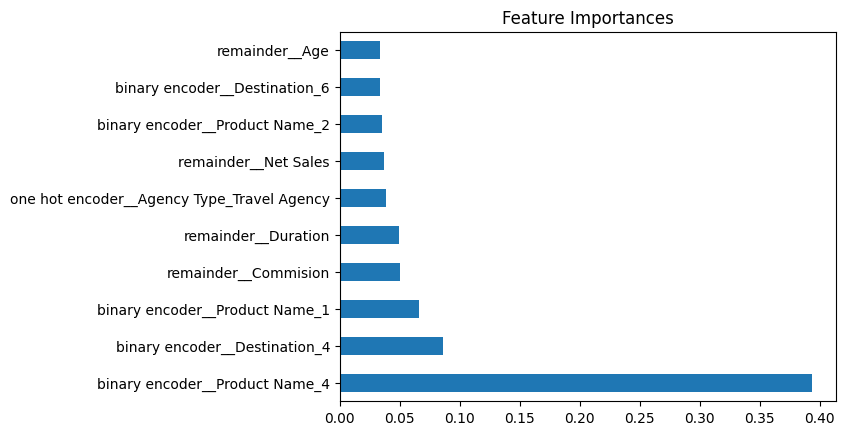

In [123]:
coef1 = pd.Series(xgb_tuning['model'].feature_importances_, transformer.get_feature_names_out()).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

Berdasarkan visualisasi diatas, ada beberapa fitur yang berpengaruh dalam menentukan pengguna yang melakukan claim dan tidak. fitur-fiturnya adalah berikut ini.
- `Product Name` atau nama produk asuransi
- `Destination` destinasi dari perjalanan

### Perbandingan hasil sebelum Tuning dan sesudah Tuning

In [128]:
print('Recall score Benchmark model pada test set :', recall_score(y_test, y_pred))
print('Recall score Setelah Tuning model pada test set :', recall_score_xgb_tuning)

Recall score Benchmark model pada test set : 0.8962962962962963
Recall score Setelah Tuning model pada test set : 0.8962962962962963


dapat kita lihat bahwa model XGB Classifier setelah kita lakukan hyperparameter tuning memiliki Recall score yang sama ketika sebelum tuning dan setelah tuning. Oleh karena itu kita akan menggunakan model XGB Classifier setelah tuning sebagai model akhir. Selanjutnya kita akan melakukan membahas mengenai classification report dari XGB Classifier Setelah tuning.

In [129]:
print(classification_report(y_test, y_pred_xgb_tuning))

              precision    recall  f1-score   support

           0       0.98      0.08      0.15      7798
           1       0.02      0.90      0.03       135

    accuracy                           0.09      7933
   macro avg       0.50      0.49      0.09      7933
weighted avg       0.96      0.09      0.15      7933



## Kesimpulan

Berlandaskan hasil classification report dari model kita yang telah dijelaskan, model saat ini memiliki presisi yang tinggi untuk kelas negatif namun recall yang rendah, yang berarti model jarang memprediksi negatif tetapi ketika melakukannya, prediksinya akurat. Untuk kelas positif, presisi rendah tetapi recall tinggi, mengindikasikan bahwa model memprediksi kebanyakan kasus positif dengan benar tetapi dengan banyak kesalahan positif.

Tanpa Model

Jika kita asumsikan biaya marketing per pelanggan untuk semua pelanggan adalah $10.
    - Total Biaya: $10 × 7933 (berdasarkan angka support) = $79,330
    - Biaya yang Terbuang: $79,330

Dengan Model

- Jumlah True Positives : 0.90 × 135 = 121.5 = 122
- Jumlah False Negatives : 135 - 122 = 13
- Jumlah True Negatives : 0.98 × 7798 = 7642.04 = 7642
- Jumlah False Positives : 7798 − 7642 = 156

Asumsi:
1. biaya `False Negatives` kesalahan memprediksi customer tidak akan claim, padahal aslinya akan claim (kehilangan Lifetime Value) = $1,000 
2. biaya `False Positives` setiap kesalahan memprediksi customer akan claim, padahal aslinya tidak akan claim (biaya marketing dan biaya staff) =  $100
3. benefit setiap `True Positives` model benar memprediksi yang akan claim (keuntungan margin, loyalitas pelanggan, pengurangan biaya operasional) = $500

    - Total biaya FN = $1,000 x 13 = $13,000
    - Total biaya FP = $100 × 156 = $15,600
    - Total biaya dengan model = $13,000  + $15,600 = $28,600
    - Total benefit TP = $500 × 122 = $61,000

- Total biaya menggunakan model = $61,000 - $28,600 = $32,400

- Jumlah persentasi penghematan antara tanpa model dan dengan model adalah "`$79,330` - `$32,400` = `$46,930`" adalah sekitar `59.20%`.

Dengan menggunakan model, perusahaan perusahaan mampu menghemat `$46,930` dibandingkan dengan menggunakan metode tanpa model dengan proporsi peningkatan keuntungan perusahaan sebesar `59.20%`. Pemanfataan model ini bisa berdampak positif pada keputusan strategis, termasuk alokasi sumber daya dan peningkatan produk atau layanan.

## Rekomendasi

### Rekomendasi Untuk Model

Hal-hal yang bisa dilakukan untuk mengembangkan project dan modelnya lebih baik lagi :
- Mengembangkan kebijakan yang mendorong pelanggan untuk mengisi informasi `Gender` ini bisa meningkatkan kualitas data dan potensi model untuk membuat prediksi yang lebih akurat.
- Tambahkan kolom-kolom seperti 'Jenis Perjalanan' (bisnis, liburan, dll.), 'Jumlah Penumpang' (misalnya, apakah asuransi ini untuk perorangan atau keluarga), dan 'Riwayat Klaim' (berapa kali pelanggan ini mengajukan klaim sebelumnya).
- Mencoba algorithm ML yang lain dan juga mencoba hyperparameter tuning kembali, coba gunakan teknik oversampling yang berbeda juga, seperti SMOTETomek atau SMOTEENN dan lain sebagainya. 
- Menganalisis data-data yang model kita masih salah tebak untuk mengetahui alasannya dan karakteristiknya bagaimana.
- Menambahkan feature seperti `Jenis Perjalanan` bisa membantu perusahaan untuk menyesuaikan jenis asuransi yang ditawarkan, seperti paket bisnis untuk professional dan paket keluarga untuk family vacation. Dengan adanya penambahan feature jenis perjalanan membantu perusahaan dalam mengkalkulasi premi dengan lebih akurat karena perjalanan bisnis  memiliki risiko yang lebih tinggi terkait dengan pembatalan atau perubahan jadwal, sedangkan family vacation lebih terkait dengan risiko kesehatan atau kecelakaan. 
- Dengan mempertimbangkan feature `Jumlah Penumpang` dan `Riwayat Klaim`, perusahaan dapat mengembangkan program loyalitas atau diskon untuk pelanggan yang sering bepergian tanpa klaim atau menawarkan paket asuransi keluarga.


### Rekomendasi Untuk Business

Berdasarkan feature importances, dapat kita lihat bahwa dari model XGB Classifier yang sudah kita gunakan, fitur `Product Name` adalah yang paling penting, kemudian diikuti dengan `Destination`.

Nanti kedepannya jika ingin memprediksi pemilik polis asuransi perjalanan akan melakukan claim atau tidak, perusahaan dapat disarankan untuk lebih spesifik melihat fitur dari nama produk asuransi `Product Name` dan `Destination` yang akan dikunjungi oleh pelanggan asuransi. Semakin besar dari fitur tersebut maka semakin besar juga pelanggan akan mengajukan claim asuransi.

## Saving Model

In [71]:
import pickle

In [72]:
with open('xgb_model.pkl', 'wb') as file_model:
    pickle.dump(xgb_tuning, file_model)